# Examples

In [3]:
!pip install autograd


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


## Autograd

### Autograd library

In [4]:
import autograd.numpy as np # Thinly-wrapped version of Numpy
from autograd import grad

def taylor_sine(x): # Taylor approximation to sine function
  ans = currterm = x
  i = 0
  while np.abs(currterm) > 0.001:
    currterm = -currterm * x**2 / ((2 * i + 3) * (2 * i + 2))
    ans = ans + currterm
    i += 1
  return ans

grad_sine = grad(taylor_sine)
print(f"Gradient of sin(pi) is {grad_sine(np.pi)}")

Gradient of sin(pi) is -0.9998995297042174


### PyTorch autograd

#### Manual gradient implementation

In [7]:
import numpy as np

# Compute every step manually

# Linear regression
# f = w * x

# here : f = 2 * x
X = np.array([1, 2, 3, 4], dtype=np.float32)
Y = np.array([2, 4, 6, 8], dtype=np.float32)

w = 0.0

# model output
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

# J = MSE = 1/N * (w*x - y)**2
# dJ/dw = 1/N * 2x(w*x - y)
def gradient(x, y, y_pred):
    return np.dot(2*x, y_pred - y).mean()

print(f'Prediction before training: f(5) = {forward(5):.3f}')

# Training
learning_rate = 0.01
n_iters = 20

for epoch in range(n_iters):
    # predict = forward pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)

    # calculate gradients
    dw = gradient(X, Y, y_pred)

    # update weights
    w -= learning_rate * dw

    if epoch % 2 == 0:
        print(f'epoch {epoch+1}: w = {w:.3f}, loss = {l:.8f}')

print(f'Prediction after training: f(5) = {forward(5):.3f}')

Prediction before training: f(5) = 0.000
epoch 1: w = 1.200, loss = 30.00000000
epoch 3: w = 1.872, loss = 0.76800019
epoch 5: w = 1.980, loss = 0.01966083
epoch 7: w = 1.997, loss = 0.00050332
epoch 9: w = 1.999, loss = 0.00001288
epoch 11: w = 2.000, loss = 0.00000033
epoch 13: w = 2.000, loss = 0.00000001
epoch 15: w = 2.000, loss = 0.00000000
epoch 17: w = 2.000, loss = 0.00000000
epoch 19: w = 2.000, loss = 0.00000000
Prediction after training: f(5) = 10.000


#### Automatic gradient

In [8]:
import torch

# Here we replace the manually computed gradient with autograd

# Linear regression
# f = w * x

# here : f = 2 * x
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
Y = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

# model output
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

print(f'Prediction before training: f(5) = {forward(5).item():.3f}')

# Training
learning_rate = 0.01
n_iters = 100

for epoch in range(n_iters):
    # predict = forward pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    #w.data = w.data - learning_rate * w.grad
    with torch.no_grad():
        w -= learning_rate * w.grad

    # zero the gradients after updating
    w.grad.zero_()

    if epoch % 10 == 0:
        print(f'epoch {epoch+1}: w = {w.item():.3f}, loss = {l.item():.8f}')

print(f'Prediction after training: f(5) = {forward(5).item():.3f}')

Prediction before training: f(5) = 0.000
epoch 1: w = 0.300, loss = 30.00000000
epoch 11: w = 1.665, loss = 1.16278565
epoch 21: w = 1.934, loss = 0.04506890
epoch 31: w = 1.987, loss = 0.00174685
epoch 41: w = 1.997, loss = 0.00006770
epoch 51: w = 1.999, loss = 0.00000262
epoch 61: w = 2.000, loss = 0.00000010
epoch 71: w = 2.000, loss = 0.00000000
epoch 81: w = 2.000, loss = 0.00000000
epoch 91: w = 2.000, loss = 0.00000000
Prediction after training: f(5) = 10.000


### Jax autograd
JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.

In [9]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.PRNGKey(0)

In [10]:
grad_tanh = grad(jnp.tanh)
print(grad_tanh(2.0))

0.070650816


In [11]:
print(grad(grad(jnp.tanh))(2.0))
print(grad(grad(grad(jnp.tanh)))(2.0))

-0.13621868
0.25265405


In [12]:
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])

# Training loss is the negative log-likelihood of the training examples.
def loss(W, b):
    preds = predict(W, b, inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.sum(jnp.log(label_probs))

# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())

In [13]:
# Differentiate `loss` with respect to the first positional argument:
W_grad = grad(loss, argnums=0)(W, b)
print('W_grad', W_grad)

# Since argnums=0 is the default, this does the same thing:
W_grad = grad(loss)(W, b)
print('W_grad', W_grad)

# But we can choose different values too, and drop the keyword:
b_grad = grad(loss, 1)(W, b)
print('b_grad', b_grad)

# Including tuple values
W_grad, b_grad = grad(loss, (0, 1))(W, b)
print('W_grad', W_grad)
print('b_grad', b_grad)

W_grad [-0.16965583 -0.8774644  -1.4901346 ]
W_grad [-0.16965583 -0.8774644  -1.4901346 ]
b_grad -0.29227245
W_grad [-0.16965583 -0.8774644  -1.4901346 ]
b_grad -0.29227245


This `grad` API has a direct correspondence to the excellent notation in Spivak's classic *Calculus on Manifolds* (1965), also used in Sussman and Wisdom's [*Structure and Interpretation of Classical Mechanics*](http://mitpress.mit.edu/sites/default/files/titles/content/sicm_edition_2/book.html) (2015) and their [*Functional Differential Geometry*](https://mitpress.mit.edu/books/functional-differential-geometry) (2013). Both books are open-access. See in particular the "Prologue" section of *Functional Differential Geometry* for a defense of this notation.

Essentially, when using the `argnums` argument, if `f` is a Python function for evaluating the mathematical function $f$, then the Python expression `grad(f, i)` evaluates to a Python function for evaluating $\partial_i f$.

In [14]:
from jax import value_and_grad
loss_value, Wb_grad = value_and_grad(loss, (0, 1))(W, b)
print('loss value', loss_value)
print('loss grad', Wb_grad)

loss value 3.0519388
loss grad (Array([-0.16965583, -0.8774644 , -1.4901346 ], dtype=float32), Array(-0.29227245, dtype=float32))


#### Numerical vs automatic difference

In [15]:
# Set a step size for finite differences calculations
eps = 1e-4

# Check b_grad with scalar finite differences
b_grad_numerical = (loss(W, b + eps / 2.) - loss(W, b - eps / 2.)) / eps
print('b_grad_numerical', b_grad_numerical)
print('b_grad_autodiff', grad(loss, 1)(W, b))

# Check W_grad with finite differences in a random direction
key, subkey = random.split(key)
vec = random.normal(subkey, W.shape)
unitvec = vec / jnp.sqrt(jnp.vdot(vec, vec))
W_grad_numerical = (loss(W + eps / 2. * unitvec, b) - loss(W - eps / 2. * unitvec, b)) / eps
print('W_dirderiv_numerical', W_grad_numerical)
print('W_dirderiv_autodiff', jnp.vdot(grad(loss)(W, b), unitvec))

b_grad_numerical -0.29325485
b_grad_autodiff -0.29227245
W_dirderiv_numerical -0.2002716
W_dirderiv_autodiff -0.19909117


JAX provides a simple convenience function that does essentially the same thing, but checks up to any order of differentiation that you like:

In [16]:
from jax.test_util import check_grads
check_grads(loss, (W, b), order=2)  # check up to 2nd order derivatives

# Forward vs Reverse mode AD

$$
f(x) = \max_{i = 1, \ldots, n} (Ax)_i
$$

  0%|          | 0/20 [00:00<?, ?it/s]

🤖 Input/Output ratio 0.01
🤖 Forward time
The slowest run took 37.12 times longer than the fastest. This could mean that an intermediate result is being cached.
57.5 µs ± 117 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
🤖 Reverse time
The slowest run took 101.19 times longer than the fastest. This could mean that an intermediate result is being cached.
49.1 µs ± 112 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
🤖 Input/Output ratio 0.02
🤖 Forward time
9.24 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 50 loops each)
🤖 Reverse time
3.49 µs ± 71.3 ns per loop (mean ± std. dev. of 7 runs, 50 loops each)
🤖 Input/Output ratio 0.03
🤖 Forward time
The slowest run took 45.70 times longer than the fastest. This could mean that an intermediate result is being cached.
69.7 µs ± 141 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
🤖 Reverse time
The slowest run took 146.48 times longer than the fastest. This could mean that an intermediate result is being cached.
90.

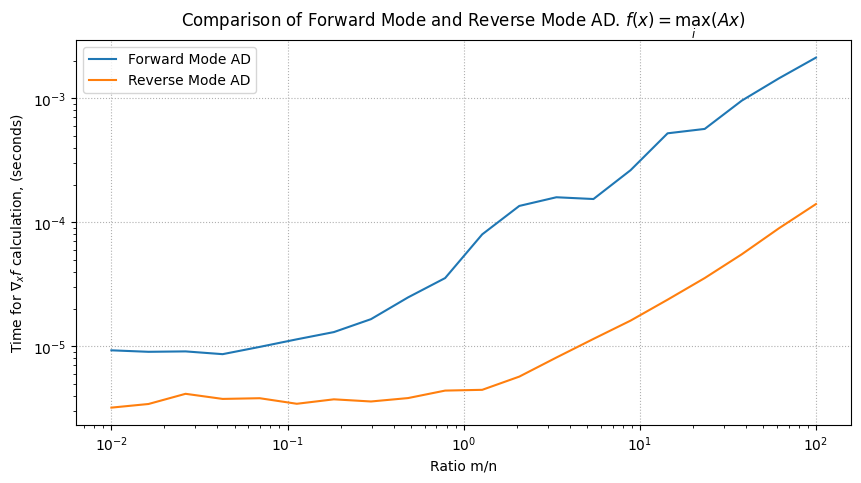

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Fixing the value of n
n = 100

# Function to calculate the product of two matrices
def matvec(A, x):
    return jnp.max(A @ x)

# Wrapper functions to calculate the Jacobian using forward and reverse mode AD
@jax.jit
def jac_fwd(A, x):
    return jax.jacfwd(matvec, argnums=1)(A, x)

@jax.jit
def jac_rev(A, x):
    return jax.jacrev(matvec, argnums=1)(A, x)

# Range of m values
m_values = jnp.logspace(0, 4, 20, dtype=jnp.float32)

# Lists to store timing results
times_fwd = []
times_rev = []

# Perform timing using %%timeit for each value of m
for m in tqdm(m_values):
    A = jax.random.normal(jax.random.PRNGKey(0), (int(m), n))
    x = jax.random.normal(jax.random.PRNGKey(1), (n, 1))

    print(f"🤖 Input/Output ratio {m/n:.2f}")

    print(f"🤖 Forward time")
    
    # Forward mode timing
    fwd_timing = %timeit -n 50 -o jac_fwd(A, x).block_until_ready()
    times_fwd.append(fwd_timing.best)

    print(f"🤖 Reverse time")
    
    # Reverse mode timing
    rev_timing = %timeit -n 50 -o jac_rev(A, x).block_until_ready()
    times_rev.append(rev_timing.best)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot([m_value / n for m_value in m_values], times_fwd, label='Forward Mode AD')
plt.plot([m_value / n for m_value in m_values], times_rev, label='Reverse Mode AD')
plt.xlabel('Ratio m/n')
plt.ylabel(r'Time for $\nabla_x f$ calculation, (seconds)')
plt.title(r'Comparison of Forward Mode and Reverse Mode AD. $f(x) = \max_i(Ax)$')
plt.legend()
plt.grid(linestyle=":")
plt.xscale('log')
plt.yscale('log') 
plt.savefig("forward_vs_reverse_ad_scalar_output.svg")
plt.show()

$$
f(x) = Ax
$$

  0%|          | 0/20 [00:00<?, ?it/s]

🤖 Input/Output ratio 0.01
🤖 Forward time
The slowest run took 323.00 times longer than the fastest. This could mean that an intermediate result is being cached.
421 µs ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
🤖 Reverse time
The slowest run took 783.68 times longer than the fastest. This could mean that an intermediate result is being cached.
315 µs ± 765 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
🤖 Input/Output ratio 0.02
🤖 Forward time
9.21 µs ± 608 ns per loop (mean ± std. dev. of 7 runs, 5 loops each)
🤖 Reverse time
3.17 µs ± 379 ns per loop (mean ± std. dev. of 7 runs, 5 loops each)
🤖 Input/Output ratio 0.03
🤖 Forward time
The slowest run took 390.02 times longer than the fastest. This could mean that an intermediate result is being cached.
503 µs ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
🤖 Reverse time
The slowest run took 1051.40 times longer than the fastest. This could mean that an intermediate result is being cached.
488 µs 

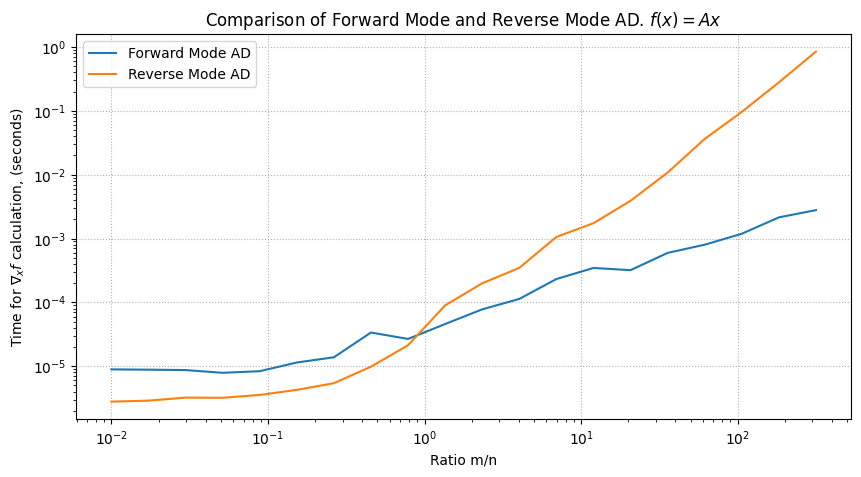

In [32]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Fixing the value of n
n = 100

# Function to calculate the product of two matrices
def matvec(A, x):
    return A@x

# Wrapper functions to calculate the Jacobian using forward and reverse mode AD
@jax.jit
def jac_fwd(A, x):
    return jax.jacfwd(matvec, argnums=1)(A, x)

@jax.jit
def jac_rev(A, x):
    return jax.jacrev(matvec, argnums=1)(A, x)

# Range of m values
m_values = jnp.logspace(0, 4.5, 20, dtype=jnp.float32)

# Lists to store timing results
times_fwd = []
times_rev = []

# Perform timing using %%timeit for each value of m
for m in tqdm(m_values):
    A = jax.random.normal(jax.random.PRNGKey(0), (int(m), n))
    x = jax.random.normal(jax.random.PRNGKey(1), (n, 1))

    print(f"🤖 Input/Output ratio {m/n:.2f}")

    print(f"🤖 Forward time")
    
    # Forward mode timing
    fwd_timing = %timeit -n 5 -o jac_fwd(A, x).block_until_ready()
    times_fwd.append(fwd_timing.best)

    print(f"🤖 Reverse time")
    
    # Reverse mode timing
    rev_timing = %timeit -n 5 -o jac_rev(A, x).block_until_ready()
    times_rev.append(rev_timing.best)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot([m_value / n for m_value in m_values], times_fwd, label='Forward Mode AD')
plt.plot([m_value / n for m_value in m_values], times_rev, label='Reverse Mode AD')
plt.xlabel('Ratio m/n')
plt.ylabel(r'Time for $\nabla_x f$ calculation, (seconds)')
plt.title(r'Comparison of Forward Mode and Reverse Mode AD. $f(x) = Ax$')
plt.legend()
plt.grid(linestyle=":")
plt.xscale('log')
plt.yscale('log') 
plt.savefig("forward_vs_reverse_ad.svg")
plt.show()

# Sources
* [HIPS autograd](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md)
* [PyTorch autograd](https://www.python-engineer.com/courses/pytorchbeginner/05-gradient-descent/)
* [Jax Autodiff cookbook](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/autodiff_cookbook.ipynb#scrollTo=RsQSyT5p7OJW)